In [159]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Importing Normalisation library
from sklearn.preprocessing import MinMaxScaler

# Importing Keras libraries and Packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Importing Metrics libraries
import math
from sklearn.metrics import mean_squared_error

# Importing TPU Setup Libraries
# tf.enable_eager_execution()
# from keras.backend import clear_session

In [160]:
data_train = pd.read_csv('https://raw.githubusercontent.com/CallMeAmartya/Food-Demand-Forecasting/master/train.csv')

**Data Preprocessing**

In [161]:
data_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
training_set = data_train.iloc[:, 1:2].values
training_set

array([[  1],
       [  1],
       [  1],
       ...,
       [145],
       [145],
       [145]])

**Feature Scaling**

In [ ]:
sc = MinMaxScaler(feature_range= (0,1))

In [ ]:
scaled_training_set = sc.fit_transform(training_set)
scaled_training_set

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

**Creating Datastructure with 60 timesteps and 1 output**

In [ ]:
# Using Pandas and Slicing

x_train, y_train = zip(*[(scaled_training_set[i-60:i, 0]
                          ,scaled_training_set[i, 0])
                          for i in range(60, 767)])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape[1]

60

**Reshaping**

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**Setting Model Parameters**

In [ ]:
INPUT_SHAPE = (x_train.shape[1], 1)
BATCH_SIZE = 32

**Model Creation**

In [ ]:
# Step 1 - Initialising the RNN
rnn_regressor = Sequential()

In [ ]:
# Step 2 - First LSTM and Droput Layer
rnn_regressor.add(LSTM(units = 50, return_sequences = True, input_shape = INPUT_SHAPE))
rnn_regressor.add(Dropout(0.2))

In [ ]:
# Step 3 - Additional LSTM and Dropout Layers
rnn_regressor.add(LSTM(units = 50, return_sequences = True))
rnn_regressor.add(Dropout(0.2))

rnn_regressor.add(LSTM(units = 75, return_sequences = True))
rnn_regressor.add(Dropout(0.2))

rnn_regressor.add(LSTM(units = 100, return_sequences = True))
rnn_regressor.add(Dropout(0.2))

rnn_regressor.add(LSTM(units = 100))
rnn_regressor.add(Dropout(0.2))

In [ ]:
# Step 4 - Full Connection
rnn_regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
rnn_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# Summary of RNN model
rnn_regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 75)            37800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 75)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 100)           7

**Train the RNN Model**

In [ ]:
EPOCHS = 100
history = rnn_regressor.fit(
    x = x_train,
    y = y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE
)

Epoch 1/100
23/23 [==============================] - 12s 176ms/step - loss: 0.0000e+00
Epoch 2/100
23/23 [==============================] - 5s 203ms/step - loss: 0.0000e+00
Epoch 3/100
23/23 [==============================] - 4s 191ms/step - loss: 0.0000e+00
Epoch 4/100
23/23 [==============================] - 4s 194ms/step - loss: 0.0000e+00
Epoch 5/100
23/23 [==============================] - 5s 198ms/step - loss: 0.0000e+00
Epoch 6/100
23/23 [==============================] - 4s 184ms/step - loss: 0.0000e+00
Epoch 7/100
23/23 [==============================] - 5s 198ms/step - loss: 0.0000e+00
Epoch 8/100
23/23 [==============================] - 5s 218ms/step - loss: 0.0000e+00
Epoch 9/100
23/23 [==============================] - 5s 234ms/step - loss: 0.0000e+00
Epoch 10/100
23/23 [==============================] - 4s 195ms/step - loss: 0.0000e+00
Epoch 11/100
23/23 [==============================] - 4s 191ms/step - loss: 0.0000e+00
Epoch 12/100
23/23 [==============================]

**Prediction and Visualising the result**

In [162]:
data_test = pd.read_csv('https://raw.githubusercontent.com/CallMeAmartya/Food-Demand-Forecasting/master/test.csv')

In [163]:
abc = data_test.iloc[:, 1:2].values

In [164]:
abc

array([[146],
       [146],
       [146],
       ...,
       [155],
       [155],
       [155]])

In [165]:
data_total = pd.concat((data_train['checkout_price'], data_test['checkout_price']), axis = 0)
inputs = data_total[len(data_total) - len(data_test) - 60:].values  # values for making this a numpy array

# Reshaping
inputs = inputs.reshape(-1,1)

In [166]:
# Scaling
inputs = sc.transform(inputs) 
# transform must be used instead of fit_transform to apply the same tranformation which occured in the training set 

In [167]:
# Creating Datastructure with 60 timesteps for test data
x_test = [inputs[i-60:i, 0] for i in range(60, 80)]   
x_test = np.array(x_test)

In [168]:
# Reshaping
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

**Prediction of Test Data with Trained RNN**

In [169]:
predicted_fooddemand = rnn_regressor.predict(x_test)

In [170]:
# Inversing the scaled data to original
predicted_fooddemand = sc.inverse_transform(predicted_fooddemand)

In [171]:
predicted_fooddemand

array([[8.395602 ],
       [8.412399 ],
       [8.414616 ],
       [8.399624 ],
       [8.365075 ],
       [8.309929 ],
       [8.234281 ],
       [8.139684 ],
       [8.0295315],
       [7.907877 ],
       [7.781517 ],
       [7.662464 ],
       [7.5530524],
       [7.4588747],
       [7.3833995],
       [7.3279247],
       [7.2927017],
       [7.278244 ],
       [7.2804112],
       [7.296183 ]], dtype=float32)

**Visualisation**

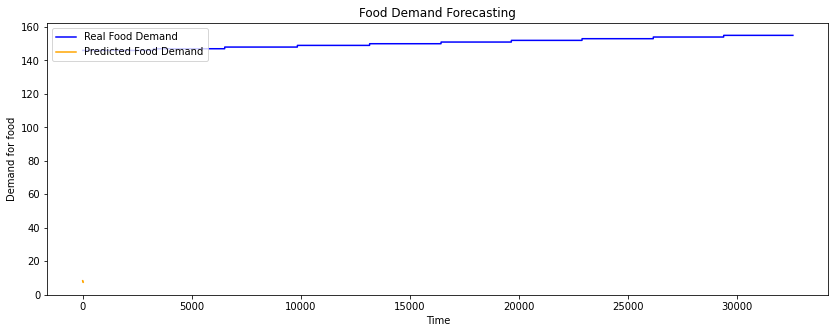

In [172]:
plt.figure(figsize=(14,5))
plt.plot(abc, color = 'blue', label = 'Real Food Demand')
plt.plot(predicted_fooddemand, color = 'orange', label = 'Predicted Food Demand')
plt.title('Food Demand Forecasting')
plt.xlabel('Time')
plt.ylabel('Demand for food')
plt.legend(loc='upper left')
plt.show()